# Calibration Walkthrough: `calibrate_mdp_params`

This notebook explains how `src/discount_engine/core/calibration.py::calibrate_mdp_params` builds MDP parameters from processed Dunnhumby data.

It mirrors the implementation step-by-step and shows intermediate outputs.

## Prerequisites

Run preprocessing first so `data/processed/transaction_data.(parquet|csv)` and `data/processed/product.(parquet|csv)` exist:

```bash
python scripts/data/preprocess_data.py --raw-dir data/raw --processed-dir data/processed --format csv
```

In [1]:
from pathlib import Path
import time
import yaml
import numpy as np
import pandas as pd

from discount_engine.core import calibration as calib
from discount_engine.core.calibration import calibrate_mdp_params
from discount_engine.core.params import load_mdp_params


In [2]:
processed_dir = Path("../data/processed")
output_path = processed_dir / "mdp_params.yaml"

print(f"processed_dir: {processed_dir}")
print(f"processed_dir exists: {processed_dir.exists()}")
print(f"output path: {output_path}")

processed_dir: ../data/processed
processed_dir exists: True
output path: ../data/processed/mdp_params.yaml


## Step 1: Load Processed Tables with Format Fallback

`_load_processed_tables_with_fallback` tries Parquet first, then CSV.

In [3]:
tables, file_format = calib._load_processed_tables_with_fallback(processed_dir)
print("file_format:", file_format)
print("tables:", list(tables.keys()))
for name, df in tables.items():
    print(f"{name}: {df.shape}")

file_format: parquet
tables: ['product', 'transaction_data']
product: (92353, 7)
transaction_data: (2595732, 12)


## Step 2: Clean Transactions and Product Tables

These helpers ensure required columns exist, coerce numeric fields, and filter invalid rows.

In [4]:
transactions = calib._prepare_transactions(tables["transaction_data"])
products = calib._prepare_products(
    tables["product"],
    product_ids=set(transactions["product_id"]),
    category_column="commodity_desc",
)

print("transactions:", transactions.shape)
print("products:", products.shape)
display(transactions.head())
display(products.head())

transactions: (2581266, 12)
products: (92015, 7)


,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


## Step 3: Merge, Build Price/Discount Signals, Select Categories, Build Panel

The panel is a household-time-category grid with:
- `purchased` (0/1 target)
- `discount_rate` (leave-one-household-out category-time level)
- `deal_signal` (positive centered promotion anomaly)
- `recency` (time since previous purchase)
- `cat_idx`


In [5]:
category_column = "commodity_desc"
n_categories = 5  # keep walkthrough fast

merged = transactions.merge(
    products[["product_id", category_column]],
    on="product_id",
    how="inner",
)
merged = calib._compute_price_and_discount_signals(merged)
selected_categories = calib._select_top_categories(
    merged=merged,
    category_column=category_column,
    n_categories=n_categories,
)
merged = merged[merged[category_column].isin(selected_categories)].copy()
time_column = calib._detect_time_column(merged)
panel, category_to_idx = calib._build_purchase_panel(
    merged=merged,
    category_column=category_column,
    selected_categories=selected_categories,
    time_column=time_column,
)

print("selected_categories:", selected_categories)
print("time_column:", time_column)
print("panel shape:", panel.shape)
print("category_to_idx:", category_to_idx)

has_discount = panel["discount_rate"] > 1e-12
has_signal = panel["deal_signal"] > 1e-12
print("discount>0 share overall:", round(float(has_discount.mean()), 6))
print("discount>0 share | purchased:", round(float((has_discount & (panel.purchased==1)).sum()/max((panel.purchased==1).sum(),1)), 6))
print("discount>0 share | no purchase:", round(float((has_discount & (panel.purchased==0)).sum()/max((panel.purchased==0).sum(),1)), 6))
print("deal_signal>0 share overall:", round(float(has_signal.mean()), 6))
print("deal_signal>0 share | purchased:", round(float((has_signal & (panel.purchased==1)).sum()/max((panel.purchased==1).sum(),1)), 6))
print("deal_signal>0 share | no purchase:", round(float((has_signal & (panel.purchased==0)).sum()/max((panel.purchased==0).sum(),1)), 6))

display(panel.head(10))


selected_categories: ['SOFT DRINKS', 'FLUID MILK PRODUCTS', 'BAKED BREAD/BUNS/ROLLS', 'CHEESE', 'BAG SNACKS']
time_column: day
panel shape: (703360, 13)
category_to_idx: {'SOFT DRINKS': 0, 'FLUID MILK PRODUCTS': 1, 'BAKED BREAD/BUNS/ROLLS': 2, 'CHEESE': 3, 'BAG SNACKS': 4}
discount>0 share overall: 0.999906
discount>0 share | purchased: 0.99984
discount>0 share | no purchase: 0.99995
deal_signal>0 share overall: 0.70992
deal_signal>0 share | purchased: 0.701746
deal_signal>0 share | no purchase: 0.715393


,household_key,day,commodity_desc,discount_sum,discount_count,household_discount_sum,household_discount_count,category_discount_baseline,purchased,discount_rate,deal_signal,recency,cat_idx
0,1,51,BAG SNACKS,7.447879,42,0.000000,0.0,-0.0,0,0.177330,0.177330,0.0,4
1,1,67,BAG SNACKS,15.155517,72,0.371237,1.0,-0.0,1,0.208229,0.208229,0.0,4
2,1,88,BAG SNACKS,17.017082,92,0.884615,2.0,-0.0,1,0.179250,0.179250,21.0,4
3,1,94,BAG SNACKS,13.510199,65,0.000000,0.0,-0.0,0,0.207849,0.207849,6.0,4
4,1,101,BAG SNACKS,28.079365,135,0.442586,1.0,-0.0,1,0.206245,0.206245,13.0,4
5,1,108,BAG SNACKS,18.002154,120,0.000000,0.0,-0.0,0,0.150018,0.150018,7.0,4
6,1,111,BAG SNACKS,9.695913,84,0.000000,0.0,-0.0,0,0.115428,0.115428,10.0,4
7,1,128,BAG SNACKS,14.273607,100,0.408027,1.0,-0.0,1,0.140056,0.140056,27.0,4
8,1,137,BAG SNACKS,9.128853,121,0.196787,2.0,-0.0,1,0.075059,0.075059,9.0,4
9,1,146,BAG SNACKS,6.814794,86,0.000000,2.0,-0.0,1,0.081128,0.081128,9.0,4


## Step 4: Fit Logistic Purchase Model over Alpha Grid (Validation-Based)

For each alpha candidate:
1. compute gap-aware memory feature
2. fit bounded logistic model on train split
3. select alpha by **validation** negative log-likelihood


In [7]:
alpha_candidates = (0.8, 0.9, 0.95, 0.99)
validation_fraction = 0.20

fitted = calib._fit_logistic_grid(
    panel=panel,
    category_to_idx=category_to_idx,
    alpha_candidates=alpha_candidates,
    validation_fraction=validation_fraction,
)

print("best alpha:", fitted.alpha)
print("deal_coef:", fitted.deal_coef)
print("recency_coef:", fitted.recency_coef)
print("memory_coef:", fitted.memory_coef)
print("selection neg_log_likelihood:", fitted.neg_log_likelihood)
print("train neg_log_likelihood:", fitted.train_neg_log_likelihood)
print("validation neg_log_likelihood:", fitted.val_neg_log_likelihood)
print("num intercepts:", len(fitted.intercepts))


Fitting logistic grid: 100%|██████████| 4/4 [00:54<00:00, 13.56s/it]

best alpha: 0.9
deal_coef: 1.286588676556532
recency_coef: 0.005720862086247983
memory_coef: 0.5939550135331052
selection neg_log_likelihood: 91658.85924716652
train neg_log_likelihood: 367623.9262284636
validation neg_log_likelihood: 91658.85924716652
num intercepts: 5


## Step 4b: Train/Validation Objective vs Alpha

This scans a denser alpha grid and records train/validation objective values,
coefficient values, and fit time per alpha.


time split cutoff: 582.0
train rows: 563495 validation rows: 139865


Best alpha in scan: 0.912 with val_nll=91658.227


,alpha,train_nll,val_nll,deal_coef,recency_coef,memory_coef,fit_seconds
0,0.8000,367701.438239,91692.458775,1.285613,0.005579,0.820877,21.711186
1,0.8750,367626.395706,91663.428520,1.287492,0.005688,0.686720,9.975586
2,0.8875,367622.662012,91660.724291,1.282875,0.005700,0.643045,7.779622
3,0.9000,367623.691873,91658.776284,1.278257,0.005713,0.593344,8.046042
4,0.9125,367630.699974,91658.226622,1.271087,0.005721,0.536463,9.933273
5,0.9250,367645.364669,91659.022351,1.266800,0.005731,0.471647,8.151964
6,0.9500,367707.730449,91668.346936,1.259331,0.005722,0.320473,8.926251
7,0.9900,368005.491995,91762.947455,1.232363,0.005514,0.047036,8.161499


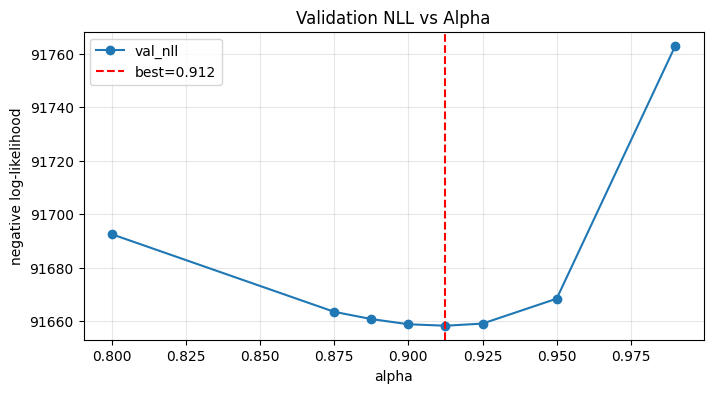

In [13]:
import tqdm
import matplotlib.pyplot as plt

panel_for_memory = panel.sort_values(
    ["household_key", "cat_idx", time_column], kind="mergesort"
).reset_index(drop=True)
cache = calib._build_sequence_cache(panel_for_memory, time_column=time_column)

y = panel_for_memory["purchased"].to_numpy(dtype=float)
deal = panel_for_memory["deal_signal"].to_numpy(dtype=float)
recency = panel_for_memory["recency"].to_numpy(dtype=float)
cat_idx = panel_for_memory["cat_idx"].to_numpy(dtype=int)
times = pd.to_numeric(panel_for_memory[time_column], errors="coerce").to_numpy(dtype=float)

train_mask, val_mask, cutoff = calib._build_time_split_masks(
    times=times,
    validation_fraction=validation_fraction,
)
if (
    (not train_mask.any())
    or np.unique(y[train_mask]).size < 2
    or (val_mask.any() and np.unique(y[val_mask]).size < 2)
):
    train_mask = np.ones(len(y), dtype=bool)
    val_mask = np.zeros(len(y), dtype=bool)

print("time split cutoff:", cutoff)
print("train rows:", int(train_mask.sum()), "validation rows:", int(val_mask.sum()))

alpha_scan = [0.8, 0.875,0.8875, 0.9, 0.9125, 0.925, 0.95, 0.99]
rows = []
theta_seed = None

for alpha in tqdm.tqdm(alpha_scan, desc="Validation sweep", leave=False):
    t0 = time.perf_counter()
    memory = calib._compute_memory_feature(
        panel_for_memory,
        alpha=alpha,
        sequence_cache=cache,
    )

    fit_alpha = calib._fit_logistic_once(
        y=y[train_mask],
        category_idx=cat_idx[train_mask],
        deal=deal[train_mask],
        recency=recency[train_mask],
        memory=memory[train_mask],
        n_categories=len(category_to_idx),
        alpha=alpha,
        initial_theta=theta_seed,
    )

    train_nll = calib._evaluate_neg_log_likelihood(
        y=y[train_mask],
        category_idx=cat_idx[train_mask],
        deal=deal[train_mask],
        recency=recency[train_mask],
        memory=memory[train_mask],
        intercepts=fit_alpha.intercepts,
        deal_coef=fit_alpha.deal_coef,
        recency_coef=fit_alpha.recency_coef,
        memory_coef=fit_alpha.memory_coef,
    )
    if val_mask.any():
        val_nll = calib._evaluate_neg_log_likelihood(
            y=y[val_mask],
            category_idx=cat_idx[val_mask],
            deal=deal[val_mask],
            recency=recency[val_mask],
            memory=memory[val_mask],
            intercepts=fit_alpha.intercepts,
            deal_coef=fit_alpha.deal_coef,
            recency_coef=fit_alpha.recency_coef,
            memory_coef=fit_alpha.memory_coef,
        )
    else:
        val_nll = train_nll

    rows.append({
        "alpha": alpha,
        "train_nll": train_nll,
        "val_nll": val_nll,
        "deal_coef": fit_alpha.deal_coef,
        "recency_coef": fit_alpha.recency_coef,
        "memory_coef": fit_alpha.memory_coef,
        "fit_seconds": time.perf_counter() - t0,
    })

    theta_seed = np.concatenate([
        fit_alpha.intercepts,
        np.array([fit_alpha.deal_coef, fit_alpha.recency_coef, fit_alpha.memory_coef], dtype=float),
    ])

objective_df = pd.DataFrame(rows).sort_values("alpha").reset_index(drop=True)
best_row = objective_df.loc[objective_df["val_nll"].idxmin()]
print(f"Best alpha in scan: {best_row['alpha']:.3f} with val_nll={best_row['val_nll']:.3f}")
display(objective_df)

fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(objective_df["alpha"], objective_df["train_nll"], marker="o", label="train_nll")
ax.plot(objective_df["alpha"], objective_df["val_nll"], marker="o", label="val_nll")
ax.axvline(best_row["alpha"], color="red", linestyle="--", label=f"best={best_row['alpha']:.3f}")
ax.set_title("Validation NLL vs Alpha")
ax.set_xlabel("alpha")
ax.set_ylabel("negative log-likelihood")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


## Step 5: Estimate Churn Dynamics and Category Prices

In [21]:
c0, eta, churn_stats = calib._calibrate_churn_dynamics(
    merged=merged,
    time_column=time_column,
    inactivity_horizon=28,
)
category_prices = calib._estimate_category_prices(
    merged=merged,
    category_column=category_column,
    selected_categories=selected_categories,
)

print("c0:", c0)
print("eta:", eta)
print("churn_stats:", churn_stats)
print("category_prices:")
for k, v in category_prices.items():
    print(f"  {k}: {v:.4f}")


c0: 0.8692420700685343
eta: 0.0036074291964779278
churn_stats: {'churn_rate_at_horizon': 0.24215813900259334}
category_prices:
  SOFT DRINKS: 1.2900
  FLUID MILK PRODUCTS: 2.4900
  BAKED BREAD/BUNS/ROLLS: 1.9900
  CHEESE: 2.9000
  BAG SNACKS: 2.0000


## Step 6: Run End-to-End Calibration and Persist YAML

This calls the public API and writes the calibrated artifact.

For speed in this walkthrough:
- `n_categories = 5`
- `alpha_grid` uses a short list
- `validation_fraction = 0.20`


In [19]:
alpha_grid = (0.8, 0.9, 0.9125, 0.925, 0.95, 0.99)

start = time.perf_counter()
result = calibrate_mdp_params(
    processed_dir=processed_dir,
    output_path=output_path,
    n_categories=5,
    category_column="commodity_desc",
    delta=0.30,
    gamma=0.99,
    inactivity_horizon=56,
    alpha_grid=alpha_grid,
    validation_fraction=validation_fraction,
)
runtime_sec = time.perf_counter() - start

print("runtime_sec:", round(runtime_sec, 2))
print("keys:", sorted(result.keys()))
print("num categories:", len(result["categories"]))
print("saved:", output_path.exists())


Fitting logistic grid: 100%|██████████| 6/6 [01:02<00:00, 10.50s/it]


runtime_sec: 78.52
keys: ['alpha', 'beta_l', 'beta_m', 'beta_p', 'c0', 'categories', 'delta', 'eta', 'gamma', 'metadata']
num categories: 5
saved: True


In [20]:
saved = load_mdp_params(output_path)
print(saved)

payload = yaml.safe_load(output_path.read_text())
display(pd.DataFrame(payload["categories"]))

display({
    "alpha": payload["alpha"],
    "beta_p": payload["beta_p"],
    "beta_l": payload["beta_l"],
    "beta_m": payload["beta_m"],
    "fit_neg_log_likelihood": payload["metadata"].get("fit_neg_log_likelihood"),
    "fit_train_neg_log_likelihood": payload["metadata"].get("fit_train_neg_log_likelihood"),
    "fit_val_neg_log_likelihood": payload["metadata"].get("fit_val_neg_log_likelihood"),
    "alpha_selection_metric": payload["metadata"].get("alpha_selection_metric"),
    "validation_fraction": payload["metadata"].get("validation_fraction"),
    "deal_signal_mode": payload["metadata"].get("deal_signal_mode"),
    "memory_mode": payload["metadata"].get("memory_mode"),
})

display(payload["metadata"])


MDPParams(delta=0.3, gamma=0.99, alpha=0.9125, beta_p=1.2792612294245562, beta_l=0.0057199618586885, beta_m=0.5360546613362821, eta=0.0036074291964779278, c0=0.8692420700685343, categories=(CategoryParams(name='SOFT DRINKS', price=1.29, beta_0=0.0842121668895272), CategoryParams(name='FLUID MILK PRODUCTS', price=2.49, beta_0=0.04624923952682244), CategoryParams(name='BAKED BREAD/BUNS/ROLLS', price=1.99, beta_0=-0.18991706292409274), CategoryParams(name='CHEESE', price=2.9000000000000004, beta_0=-0.5917881479626261), CategoryParams(name='BAG SNACKS', price=2.0, beta_0=-0.7165455206714519)), metadata={'file_format': 'parquet', 'time_column': 'day', 'category_column': 'commodity_desc', 'n_panel_rows': 703360, 'selected_categories': ['SOFT DRINKS', 'FLUID MILK PRODUCTS', 'BAKED BREAD/BUNS/ROLLS', 'CHEESE', 'BAG SNACKS'], 'inactivity_horizon': 56, 'churn_stats': {'churn_rate_at_horizon': 0.13713268577991494}, 'fit_neg_log_likelihood': 91658.53298199747, 'fit_train_neg_log_likelihood': 36763

,name,price,beta_0
0,SOFT DRINKS,1.29,0.084212
1,FLUID MILK PRODUCTS,2.49,0.046249
2,BAKED BREAD/BUNS/ROLLS,1.99,-0.189917
3,CHEESE,2.90,-0.591788
4,BAG SNACKS,2.00,-0.716546


{'alpha': 0.9125,
 'beta_p': 1.2792612294245562,
 'beta_l': 0.0057199618586885,
 'beta_m': 0.5360546613362821,
 'fit_neg_log_likelihood': 91658.53298199747,
 'fit_train_neg_log_likelihood': 367630.798540985,
 'fit_val_neg_log_likelihood': 91658.53298199747,
 'alpha_selection_metric': 'validation_nll',
 'validation_fraction': 0.2,
 'deal_signal_mode': 'positive_centered_anomaly',
 'memory_mode': 'gap_aware_ewma'}

{'file_format': 'parquet',
 'time_column': 'day',
 'category_column': 'commodity_desc',
 'n_panel_rows': 703360,
 'selected_categories': ['SOFT DRINKS',
  'FLUID MILK PRODUCTS',
  'BAKED BREAD/BUNS/ROLLS',
  'CHEESE',
  'BAG SNACKS'],
 'inactivity_horizon': 56,
 'churn_stats': {'churn_rate_at_horizon': 0.13713268577991494},
 'fit_neg_log_likelihood': 91658.53298199747,
 'fit_train_neg_log_likelihood': 367630.798540985,
 'fit_val_neg_log_likelihood': 91658.53298199747,
 'alpha_selection_metric': 'validation_nll',
 'validation_fraction': 0.2,
 'discount_signal_mode': 'category_time_mean',
 'deal_signal_mode': 'positive_centered_anomaly',
 'memory_mode': 'gap_aware_ewma'}

## Notes

- This walkthrough inspects private helpers (`_...`) for transparency.
- Production code should call the public API `calibrate_mdp_params(...)`.
- This notebook reflects the patched calibration behavior:
  - leakage-safe deal signal
  - gap-aware memory
  - validation-based alpha selection
- Detailed investigation report: `../CALIBRATION_PATCH_INVESTIGATION.md`.


## Step 7 (Optional): Half-Life-Informed Alpha Grid

This optional cell converts half-life assumptions to alpha candidates and reruns
calibration with validation-based alpha selection.


In [ ]:
# Optional run: set to True if you want to run the half-life-informed grid.
run_half_life = False

def alpha_from_half_life(half_life_days: float, step_days: float = 1.0) -> float:
    return 0.5 ** (step_days / half_life_days)

half_life_days = [30, 60, 90, 180, 365]
alpha_from_half_life_grid = [round(alpha_from_half_life(h), 6) for h in half_life_days]
alpha_grid_half_life = tuple(sorted(set(alpha_from_half_life_grid + [0.8, 0.9, 0.95, 0.99])))

print("half_life_days:", half_life_days)
print("alpha_grid_half_life:", alpha_grid_half_life)

if run_half_life:
    result_half_life = calibrate_mdp_params(
        processed_dir=processed_dir,
        output_path=output_path,
        n_categories=5,
        category_column="commodity_desc",
        delta=0.30,
        gamma=0.99,
        inactivity_horizon=28,
        alpha_grid=alpha_grid_half_life,
        validation_fraction=validation_fraction,
    )

    print("calibrated alpha:", result_half_life["alpha"])
    print(
        "beta_p / beta_l / beta_m:",
        result_half_life["beta_p"],
        result_half_life["beta_l"],
        result_half_life["beta_m"],
    )
    display(pd.DataFrame(result_half_life["categories"]))
    display(result_half_life["metadata"])
else:
    print("Skipped optional half-life run (set run_half_life=True to execute).")
